In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import pandas as pd

calendar_df = pd.read_csv('./data/calendar.csv')
prices_df = pd.read_csv('./data/sell_prices.csv')
train_df = pd.read_csv('./data/sales_train_validation.csv')

sample_submission = pd.read_csv('./data/sample_submission.csv')
eval_df = pd.read_csv('./data/sales_train_evaluation.csv')

In [3]:
from helpers import add_forecast_period

forecast_days = 28

train_df, date_test_ids = add_forecast_period(train_df, days=forecast_days)

start_test_date = calendar_df[calendar_df['d'] == date_test_ids[0]]['date'].values[0]

In [3]:
from helpers import create_timeseries


X = create_timeseries(train_df, calendar_df) # .sample(100)

X = (X
     .merge(calendar_df, on='d', how='left')
     .sort_values(['id', 'date']))

X['is_weekend'] = X['weekday'].apply(lambda df: df in['Saturday', 'Sunday'])

# TODO check snap column
X = (X
    .assign(snap=lambda df: df.apply(lambda r: r[f'snap_{r.state_id}'], axis=1))
    .drop(['snap_CA', 'snap_TX', 'snap_WI'], axis=1))

# TODO prices has null values
X = X.merge(prices_df, on=['wm_yr_wk', 'store_id', 'item_id'], how='left')

KeyboardInterrupt: 

# Features

In [105]:
from helpers import add_lagged_features, add_rolling

def calculate_timebase_features(X):

    X = add_lagged_features(X, [1, 3, 5,  20, 31, 180, 365])   

    X = add_rolling(X, 'mean', [5, 10, 20, 50, 365])
    X = add_rolling(X, 'min', [5, 10, 20, 50,  365])
    X = add_rolling(X, 'max', [5, 10, 20, 50, 365])
    
    return X

X = calculate_timebase_features(X)

In [83]:
X_train_val, X_test = (X[X['date'] < start_test_date].reset_index(drop=True), 
                       X[X['date'] >= start_test_date].reset_index(drop=True))

In [84]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

numeric_features = [x for x in X_train_val.columns if 'lag_' in x or 'rolling_' in x]

categorical_features = [
    'dept_id', 'cat_id', 'store_id', 'state_id', 'event_type_1', # TODO add event_type_2
    'month', 'weekday', 'is_weekend', 'snap']

feature_transformer = ColumnTransformer(
     [('numeric', 'passthrough', numeric_features),
      ('categorical', OneHotEncoder(sparse=False, drop='first'), categorical_features)]
)

X_ = feature_transformer.fit_transform(X_train_val)
y_ = X_train_val['sales']

# X_test_ = feature_transformer.transform(X_test)

In [ ]:
# TODO handle nulls
# TODO add price features

# Cross validation

In [138]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.base import BaseEstimator
from lightgbm.sklearn import LGBMRegressor


from sklearn.metrics import make_scorer
from helpers import rmsse
import numpy as np

from sklearn.pipeline import Pipeline
from helpers import create_splits


# Source: https://stackoverflow.com/questions/38555650/try-multiple-estimator-in-one-grid-search    
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass
        
# Placeholder Estimator
pipe = Pipeline(
    [('estimator', DummyEstimator())]
) 

# Candidate learning algorithms and their hyperparameters
param_grid = [
    {
        'estimator': [LinearRegression(normalize=True)], # Actual Estimator
        'estimator__fit_intercept': [True, False]
    },
    {
        'estimator': [LGBMRegressor()],
        'estimator__n_estimators': [100, 300]
    }
]

gscv = GridSearchCV(
    estimator=pipe, 
    param_grid=param_grid, 
    cv=create_splits(X_train_val, n_splits=5, test_size=28),
    scoring=make_scorer(rmsse, greater_is_better=False),
    n_jobs=-1)

gscv.fit(
    X=X_, 
    y=y_,
    )

pd.DataFrame(gscv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__fit_intercept,param_estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,5.103618,3.226804,0.021026,0.001628,LGBMRegressor(),NaN,100,"{'estimator': LGBMRegressor(), 'estimator__n_e...",-0.549758,-0.584000,-0.549365,-0.544067,-0.567412,-0.558920,0.014812,1
3,4.239872,0.128352,0.075500,0.002901,LGBMRegressor(),NaN,300,"{'estimator': LGBMRegressor(), 'estimator__n_e...",-0.551983,-0.586080,-0.546364,-0.543428,-0.569739,-0.559519,0.016117,2
1,8.813505,0.151863,0.002503,0.000784,LinearRegression(normalize=True),False,NaN,{'estimator': LinearRegression(normalize=True)...,-0.591828,-0.610547,-0.585995,-0.584661,-0.569605,-0.588527,0.013230,3
0,8.899009,0.198467,0.002157,0.001023,LinearRegression(normalize=True),True,NaN,{'estimator': LinearRegression(normalize=True)...,-0.591871,-0.610566,-0.586041,-0.584664,-0.569587,-0.588546,0.013242,4


In [141]:
X_train_val['pred'] = gscv.best_estimator_.predict(X_)

# X_test['pred_test'] = gscv.best_estimator_.predict(X_test_)

# Create one dataframe for plotting
X_total = pd.concat([X_train_val, X_test])

# Feature importances

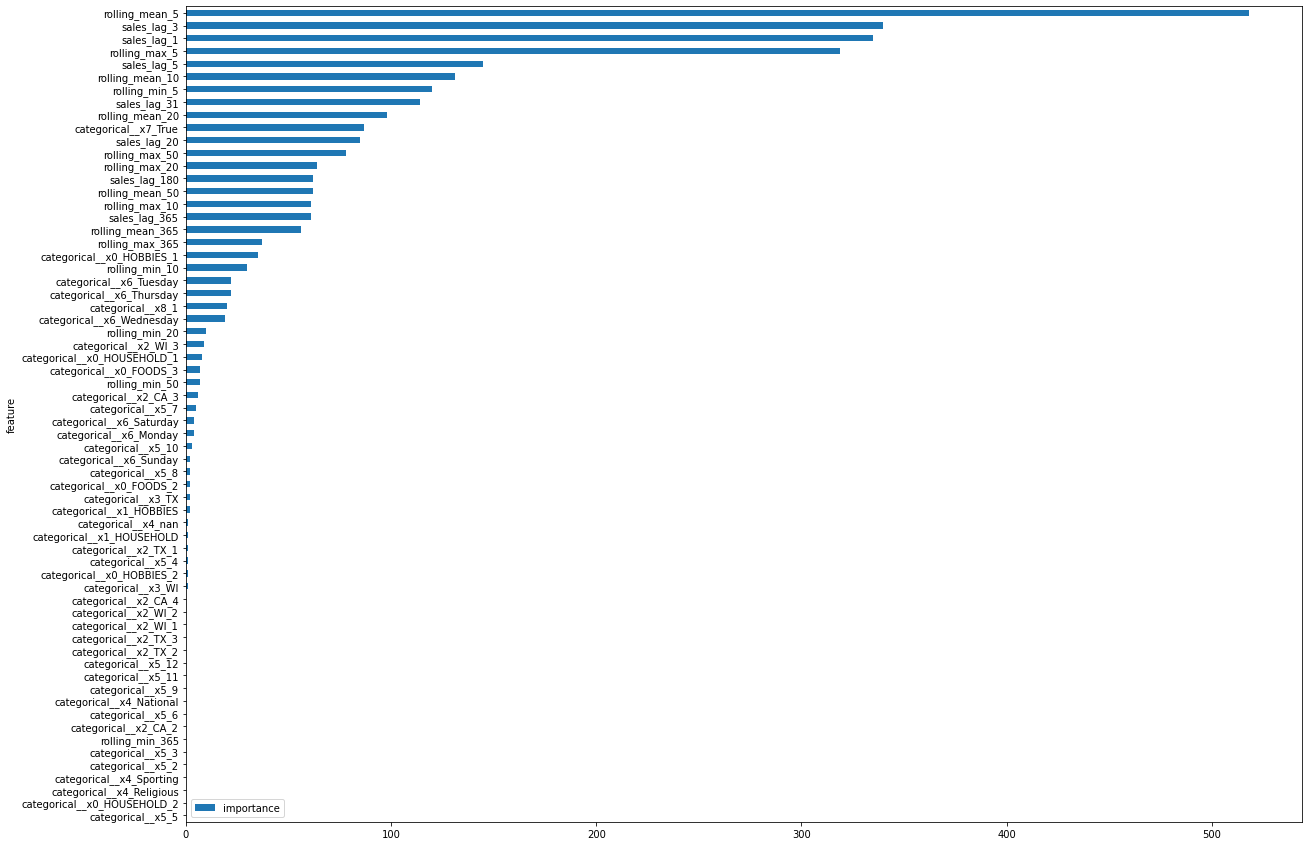

In [177]:
(
    pd.DataFrame(
        {'feature': feature_transformer.get_feature_names(),
         'importance': gscv.best_estimator_['estimator'].feature_importances_, 
        }
    )
    .sort_values('importance', ascending=True)
    .set_index('feature')
    .plot(kind='barh', figsize=(20, 15)));
    

In [27]:
X_test[X_test['d'] == d]['preds'] =  gscv.best_estimator_.predict(X_test_one_step_)

/Users/wf07pu/miniconda3/envs/m5/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [106]:


for d in date_test_ids:
    X_test_one_step = X[X['d'] == d].copy()
    X_test_one_step_ = feature_transformer.transform(X_test_one_step)
    
    # Add sales data   
    X_test_one_step['sales'] =  gscv.best_estimator_.predict(X_test_one_step_)  
    
    # Drop the row from the dataframe
    X = X.drop(X[X['d'] == d].index)
    # Add the rows with updated values
    X = (X
         .append(X_test_one_step)
         .sort_values(['id', 'date']))
    # X = X.drop([x for x in X.columns if 'rolling_' in x or 'sales_' in x], axis=1)
    X = calculate_timebase_features(X)

In [107]:
X

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,rolling_min_5,rolling_min_10,rolling_min_20,rolling_min_50,rolling_min_365,rolling_max_5,rolling_max_10,rolling_max_20,rolling_max_50,rolling_max_365
0,FOODS_1_076_TX_2_validation,FOODS_1_076,FOODS_1,FOODS,TX_2,TX,d_1,2.000000,2011-01-29,11101,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,FOODS_1_076_TX_2_validation,FOODS_1_076,FOODS_1,FOODS,TX_2,TX,d_2,0.000000,2011-01-30,11101,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,FOODS_1_076_TX_2_validation,FOODS_1_076,FOODS_1,FOODS,TX_2,TX,d_3,2.000000,2011-01-31,11101,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,FOODS_1_076_TX_2_validation,FOODS_1_076,FOODS_1,FOODS,TX_2,TX,d_4,1.000000,2011-02-01,11101,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,FOODS_1_076_TX_2_validation,FOODS_1_076,FOODS_1,FOODS,TX_2,TX,d_5,0.000000,2011-02-02,11101,...,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194095,HOUSEHOLD_2_418_TX_3_validation,HOUSEHOLD_2_418,HOUSEHOLD_2,HOUSEHOLD,TX_3,TX,d_1937,-0.143216,2016-05-18,11616,...,-0.143216,-0.143216,-0.15526,-0.228121,-0.228121,0.265235,0.265235,0.265235,2.0,3.0
194096,HOUSEHOLD_2_418_TX_3_validation,HOUSEHOLD_2_418,HOUSEHOLD_2,HOUSEHOLD,TX_3,TX,d_1938,-0.059636,2016-05-19,11616,...,-0.143216,-0.143216,-0.15526,-0.228121,-0.228121,0.265235,0.265235,0.265235,2.0,3.0
194097,HOUSEHOLD_2_418_TX_3_validation,HOUSEHOLD_2_418,HOUSEHOLD_2,HOUSEHOLD,TX_3,TX,d_1939,-0.042112,2016-05-20,11616,...,-0.143216,-0.143216,-0.15526,-0.228121,-0.228121,-0.023591,0.265235,0.265235,2.0,3.0
194098,HOUSEHOLD_2_418_TX_3_validation,HOUSEHOLD_2_418,HOUSEHOLD_2,HOUSEHOLD,TX_3,TX,d_1940,0.163111,2016-05-21,11617,...,-0.143216,-0.143216,-0.15526,-0.228121,-0.228121,0.163111,0.265235,0.265235,1.0,3.0


In [112]:
X_total['pred_test'] = X['sales']

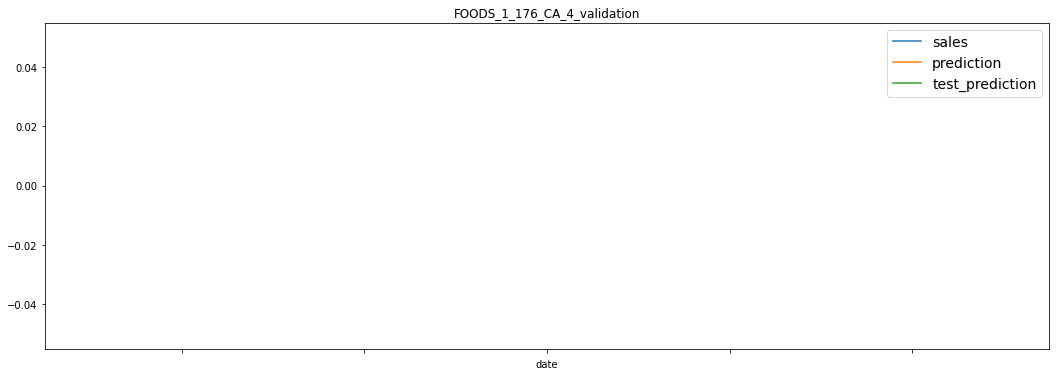

In [113]:
import matplotlib.pylab as plt

selected_id = np.unique(X['id'])[4]

selected_series = X_total[X_total['id'] == selected_id]

fig, ax = plt.subplots(figsize=(18,6))

selected_series.plot(x='date', y='sales', ax=ax, title=f"{selected_id}")
selected_series.plot(x='date', y='pred', ax=ax);
selected_series.plot(x='date', y='pred_test', ax=ax);

ax.legend(["sales", "prediction", "test_prediction"], prop={'size': 14});

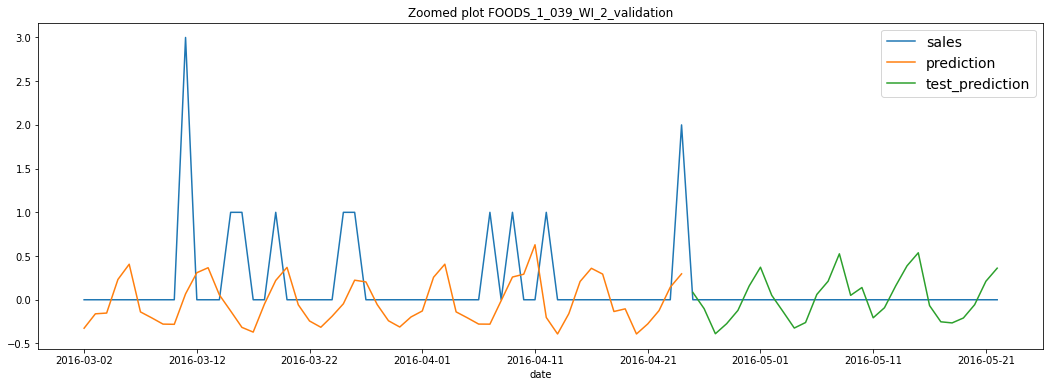

In [241]:
import matplotlib.pylab as plt

min_plot_date = '2016-03-01'

selected_id = np.unique(X['id'])[2]

selected_series = X_total[(X_total['id'] == selected_id) & (X_total['date'] > min_plot_date)]

fig, ax = plt.subplots(figsize=(18,6))

selected_series.plot(x='date', y='sales', ax=ax, title=f"Zoomed plot {selected_id}")
selected_series.plot(x='date', y='pred', ax=ax);
selected_series.plot(x='date', y='pred_test', ax=ax);

ax.legend(["sales", "prediction", "test_prediction"], prop={'size': 14});

In [263]:
from helpers import create_submission_file
    
submission_df = create_submission_file(X_test, days=forecast_days)

submission_df.to_csv('./submission.csv', index=False)

# Archive

In [137]:
from helpers import create_splits, rmsse

from sklearn.linear_model import LinearRegression

import numpy as np


rmsse_splits = []

for train_index, test_index in create_splits(X, 1, 28):
    X_train, y_train = X.loc[train_index, :].drop('sales', axis=1), X.loc[train_index, 'sales']
    X_test, y_test = X.loc[test_index, :].drop('sales', axis=1), X.loc[test_index, 'sales']
    
    # Naive prediction
    pred_train = np.array(X_train['sales_lag_1'])
    pred_test = np.array(X_test['sales_lag_1'])
    
    # Linear regression
    model = LinearRegression()
    
    model.fit(X_train.select_dtypes(include=np.number), y_train)
    
    pred_test = model.predict(X_test.select_dtypes(include=np.number))
    
    # print(rmsse(np.array(y_test), pred_test))
        
    rmsse_splits.append(rmsse(np.array(y_test), pred_test))


print(np.mean(rmsse_splits))

0.5317656367511365


In [30]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(start_p=8, max_p=9, suppress_warnings=True)

forecaster.fit(train['FOODS_1_001_CA_1_validation'])
forecaster.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1913
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3116.406
Date:                Sat, 18 Sep 2021   AIC                           6236.812
Time:                        09:04:07   BIC                           6247.924
Sample:                             0   HQIC                          6240.902
                               - 1913                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9599      0.006   -164.285      0.000      -0.971      -0.948
sigma2         1.5229      0.017     92.167      0.000       1.491       1.555
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             29339.33
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             3.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso

lasso = Lasso()

cross_validate(cv=tscv, estimator=lasso, X=train)

/Users/wf07pu/miniconda3/envs/m5/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/wf07pu/miniconda3/envs/m5/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 596, in _fit_and_score
    estimator.fit(X_train, **fit_params)
TypeError: fit() missing 1 required positional argument: 'y'

  FitFailedWarning)
/Users/wf07pu/miniconda3/envs/m5/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/wf07pu/miniconda3/envs/m5/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 596, in _fit_and_score
    estimator.fit(X_train, **fit_params)
TypeError: fit() mis

{'fit_time': array([0.2411797 , 0.21519613, 0.21239996, 0.21951079]),
 'score_time': array([0., 0., 0., 0.]),
 'test_score': array([nan, nan, nan, nan])}

In [14]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=28)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    print(len(train_index))
    print(len(test_index))
    # X_train, X_test = X[train_index], X[test_index]
    # y_train, y_test = y[train_index], y[test_index]

NameError: name 'X' is not defined

In [181]:
pd.set_option('display.max_columns', None)

In [307]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(drop='first', categories='auto', sparse=False)

num_features = [x for x in X.columns if 'lag_' in x]

cat_features = [
    'dept_id', 'cat_id', 'store_id', 
    'state_id', 'event_type_1', 'month', 'weekday', 'is_weekend']

enc.fit(X[cat_features]) # TODO add event_type_2 to event_type_1

df_cat = pd.DataFrame(enc.transform(X[cat_features]), columns=enc.get_feature_names())